In [1]:
import pandas as pd
import pubchempy as pcp

## 1. Make a drug info dataframe
- Include DrugBankID, PubchemID, SMILES

In [2]:
# pubchemID 수집
!python ./crowling/crowling_pubchem.py

In [4]:
drug_pc = pd.read_csv('./data/drug_id.csv')

In [6]:
# 수집한 pubchemID를 바탕으로 SMILES 수집
drug_pc.insert(2, "SMILES", None)
error = []
for i in range(len(drug_pc)):
    try:
        comp = pcp.get_compounds(drug_pc['Pubchem CID'][i])[0]
        drug_pc.loc[i, "SMILES"] = comp.isomeric_smiles
    except Exception as e:
        error.append(drug_pc['Pubchem CID'][i])
        print("Error: ", e)
drug_pc

In [ ]:
# SMILES 수집 실패한 케이스에 대하여 재수집 (단순 서버 오류로 실패한 경우도 존재하기 때문)
error_fin = []
for i in range(len(error)):
    try:
        comp = pcp.get_compounds(error[i])[0]
        drug_pc[drug_pc['Pubchem CID'] == error[i]]['SMILES'] = comp.isomeric_smiles
        
    except Exception as e:
        error_fin.append(error[i])
        print("Error: ", e)
drug_pc

Error:  'PUGREST.BadRequest'
Error:  'PUGREST.BadRequest'
Error:  'PUGREST.BadRequest'
Error:  'PUGREST.BadRequest'


/var/tmp/ipykernel_259941/445617646.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_pc[drug_pc['Pubchem CID'] == error[i]]['SMILES'] = comp.isomeric_smiles


Error:  'PUGREST.BadRequest'


,#Drug,Pubchem CID,SMILES
0,DB00357,2145,CCC1(CCC(=O)NC1=O)C2=CC=C(C=C2)N
1,DB02721,77022,C1=C(C=NN1)I
2,DB00773,36462,C[C@@H]1OC[C@@H]2[C@@H](O1)[C@@H]([C@H]([C@@H]...
3,DB07138,3038525,C1=CC(=C(C(=C1)Cl)C2=C3C=CC(=NN3C=NC2=O)SC4=C(...
4,DB08136,24864077,CC(=O)NC1=C(NN=C1)C(=O)NC2=CC=C(C=C2)F
...,...,...,...
4584,DB04113,17429,C1CCN(CC1)C=O
4585,DB00235,4197,CC1=C(C=C(C(=O)N1)C#N)C2=CC=NC=C2
4586,DB04249,131704274,C/C=C\1/C(=C2/C=C\3/C(=C/C)/C(=C([N-]3)/C=C\4/...
4587,DB06883,10915062,CC(C)(C)C1=NN(C(=C1)NC(=O)NC2=CC=CC=C2)C3=CC=C...


In [ ]:
# 쓰레기값 제거
drug_pc = drug_pc[drug_pc['SMILES'] != 'Not Available'].reset_index(drop=True)

# csv로 저장
drug_pc.to_csv('./data/drug_id.csv', index=False)

## 2. Make a gene info dataframe

In [ ]:
import pandas as pd

chem_gene = pd.read_csv('./data/ChG-Miner_miner-chem-gene.tsv', sep='\t')
chem_gene

,#Drug,Gene
0,DB00357,P05108
1,DB02721,P00325
2,DB00773,P23219
3,DB07138,Q16539
4,DB08136,P24941
...,...,...
15134,DB01215,P47870
15135,DB06089,P51787
15136,DB01614,P21728
15137,DB00582,P08684


In [1]:
# organism이 human인 경우만 추출
import requests
import re
url = 'https://rest.uniprot.org/uniprotkb/stream?compressed=false&format=fasta&query=%28organism_id%3A9606%29%20AND%20%28reviewed%3Atrue%29'
all_fastas = requests.get(url).text
fasta_list = re.split(r'\n(?=>)', all_fastas)

In [ ]:
chem_gene.insert(2, "Sequence", None)
for i in range(len(chem_gene)):
    for fasta in fasta_list:
        if chem_gene["Gene"][i] in fasta:
            chem_gene.loc[i, "Sequence"] = fasta.split(" ")[-1]
chem_gene

,#Drug,Gene,Sequence
0,DB00357,P05108,SV=2\nMLAKGLPPRSVLVKGCQTFLSAPREGLGRLRVPTGEGAGI...
1,DB02721,P00325,SV=3\nMSTAGKVIKCKAAVLWEVKKPFSIEDVEVAPPKAYEVRIK...
2,DB00773,P23219,SV=2\nMSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPC...
3,DB07138,Q16539,SV=3\nMSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCA...
4,DB08136,P24941,SV=2\nMENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTE...
...,...,...,...
15134,DB01215,P47870,SV=2\nMWRVRKRGYFGIWSFPLIIAAVCAQSVNDPSNMSLVKETV...
15135,DB06089,P51787,SV=3\nMAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLEL...
15136,DB01614,P21728,SV=1\nMRTLNTSAMDGTGLVVERDFSVRILTACFLSLLILSTLLG...
15137,DB00582,P08684,SV=4\nMALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPG...


In [ ]:
# Seq 앞에 붙어있는 "SV=" 제거
for i in range(len(chem_gene)):
    extended  = ''
    if not pd.isna(chem_gene['Sequence'][i]):
        seq_list = chem_gene['Sequence'][i].split('\n')[1:]
        for seq in seq_list:
            extended += seq
    chem_gene.loc[i, 'Sequence'] = extended
chem_gene

,#Drug,Gene,Sequence
0,DB00357,P05108,MLAKGLPPRSVLVKGCQTFLSAPREGLGRLRVPTGEGAGISTRSPR...
1,DB02721,P00325,MSTAGKVIKCKAAVLWEVKKPFSIEDVEVAPPKAYEVRIKMVAVGI...
2,DB00773,P23219,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...
3,DB07138,Q16539,MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKT...
4,DB08136,P24941,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...
...,...,...,...
15134,DB01215,P47870,MWRVRKRGYFGIWSFPLIIAAVCAQSVNDPSNMSLVKETVDRLLKG...
15135,DB06089,P51787,MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPA...
15136,DB01614,P21728,MRTLNTSAMDGTGLVVERDFSVRILTACFLSLLILSTLLGNTLVCA...
15137,DB00582,P08684,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...


In [ ]:
# csv로 저장
chem_gene.to_csv('./data/chem_gene_seq.csv', index=False)

## 3. Make triplets

In [ ]:
import pandas as pd

label_df = pd.read_csv('./data/DCh-Miner_miner-disease-chemical.tsv', sep='\t')
label_df.rename(columns={'Chemical': '#Drug'}, inplace=True)

In [ ]:
# 데이터가 방대하여, 일부만 사용함
label_df = label_df[:5000]

In [ ]:
# triple set 생성
import time

triplet_set = set()

# triplet = (chemical 1, chemical 2, similarity(targeting same disease / 0 or 1))
for i in range(len(label_df)):
    
    start = time.time()
    for j in range(i+1, len(label_df)):
        disease1 = label_df['# Disease(MESH)'][i]
        disease2 = label_df['# Disease(MESH)'][j]
        
        chem1 = label_df['#Drug'][i]
        chem2 = label_df['#Drug'][j]
        
        if disease1 == disease2:
            triplet = (chem1, chem2, 1)
            if triplet not in triplet_set:
                triplet_set.add(triplet)
        else:        
            triplet = (chem1, chem2, 0)
            if triplet not in triplet_set:
                triplet_set.add(triplet)
        if i % 5000 == 1:
            if j % 100000 == 1:
                print(f'i={i}, j={j}번째 완료')
            
    if i % 100 == 1:
        print(f'{i}번째 완료')
        print(i/len(label_df)*100, '% 완료')
        end = time.time()
        print(f"{(end - start):.2f}", '초 경과')
triplet_set

1번째 완료
0.02 % 완료
0.05 초 경과
101번째 완료
2.02 % 완료
0.05 초 경과
201번째 완료
4.02 % 완료
0.05 초 경과
301번째 완료
6.02 % 완료
0.05 초 경과
401번째 완료
8.02 % 완료
0.05 초 경과
501번째 완료
10.02 % 완료
0.05 초 경과
601번째 완료
12.02 % 완료
0.05 초 경과
701번째 완료
14.02 % 완료
0.05 초 경과
801번째 완료
16.02 % 완료
0.05 초 경과
901번째 완료
18.02 % 완료
0.04 초 경과
1001번째 완료
20.02 % 완료
0.04 초 경과
1101번째 완료
22.02 % 완료
0.04 초 경과
1201번째 완료
24.02 % 완료
0.04 초 경과
1301번째 완료
26.02 % 완료
0.04 초 경과
1401번째 완료
28.02 % 완료
0.04 초 경과
1501번째 완료
30.020000000000003 % 완료
0.04 초 경과
1601번째 완료
32.019999999999996 % 완료
0.04 초 경과
1701번째 완료
34.02 % 완료
0.04 초 경과
1801번째 완료
36.02 % 완료
0.04 초 경과
1901번째 완료
38.019999999999996 % 완료
0.03 초 경과
2001번째 완료
40.02 % 완료
0.03 초 경과
2101번째 완료
42.02 % 완료
0.03 초 경과
2201번째 완료
44.019999999999996 % 완료
0.03 초 경과
2301번째 완료
46.02 % 완료
0.03 초 경과
2401번째 완료
48.02 % 완료
0.03 초 경과
2501번째 완료
50.019999999999996 % 완료
0.03 초 경과
2601번째 완료
52.019999999999996 % 완료
0.03 초 경과
2701번째 완료
54.02 % 완료
0.03 초 경과
2801번째 완료
56.02 % 완료
0.02 초 경과
2901번째 완료
58.02 % 완료
0.02 초 경과
3001번째 완료

{('DB00721', 'DB01057', 0),
 ('DB00999', 'DB01132', 0),
 ('DB00440', 'DB00497', 0),
 ('DB00169', 'DB00343', 0),
 ('DB00708', 'DB00364', 0),
 ('DB00643', 'DB00870', 0),
 ('DB00790', 'DB02539', 0),
 ('DB00984', 'DB01162', 0),
 ('DB00764', 'DB00704', 0),
 ('DB04817', 'DB00318', 0),
 ('DB00685', 'DB00602', 0),
 ('DB00723', 'DB01234', 0),
 ('DB01024', 'DB00260', 0),
 ('DB00920', 'DB00191', 0),
 ('DB01436', 'DB01184', 0),
 ('DB01002', 'DB01357', 0),
 ('DB01205', 'DB01149', 0),
 ('DB02659', 'DB01034', 0),
 ('DB00721', 'DB00165', 0),
 ('DB00708', 'DB00800', 0),
 ('DB00515', 'DB00148', 0),
 ('DB00553', 'DB01189', 0),
 ('DB02998', 'DB00640', 0),
 ('DB02210', 'DB01012', 0),
 ('DB00320', 'DB00857', 0),
 ('DB04828', 'DB01424', 0),
 ('DB00370', 'DB01156', 0),
 ('DB01435', 'DB02424', 0),
 ('DB00143', 'DB01126', 0),
 ('DB01059', 'DB00420', 0),
 ('DB00986', 'DB01162', 0),
 ('DB00417', 'DB00685', 0),
 ('DB01378', 'DB00851', 0),
 ('DB01143', 'DB00415', 0),
 ('DB04840', 'DB00608', 0),
 ('DB01015', 'DB0277

In [ ]:
# triple을 df로 변환 및 저장
triplet_df = pd.DataFrame(triplet_set, columns=['Chemical 1', 'Chemical 2', 'Similarity'])

for i, tmp_tuple in enumerate(triplet_set) :
    triplet_df.loc[i,'Chemical 1'] = tmp_tuple[0]
    triplet_df.loc[i, 'Chemical 2'] = tmp_tuple[1]
    triplet_df.loc[i, 'Similarity'] = tmp_tuple[2]
    if i % (len(triplet_set)//20) == 0:
        print(i*100//len(triplet_set), "% Completed")
triplet_df.to_csv('./data/triplet.csv', index=False)

0 % Completed
4 % Completed
9 % Completed
14 % Completed
19 % Completed
24 % Completed
29 % Completed
34 % Completed
39 % Completed
44 % Completed
49 % Completed
54 % Completed
59 % Completed
64 % Completed
69 % Completed
74 % Completed
79 % Completed
84 % Completed
89 % Completed
94 % Completed
99 % Completed


In [ ]:
# set 내에는 인덱스가 없어서,
# df로 변환할 때 (Chemical 1, Chemical 2, Similarity) 순서로 저장되지 않을 수 있음
# 이를 교정해주는 작업 수행

err = []
for i in range(len(triplet_df)):
    if triplet_df['Similarity'][i] not in [0, 1]:
        if triplet_df['Chemical 1'][i] in [0, 1]:
            temp = triplet_df['Chemical 1'][i]
            triplet_df.loc[i, 'Chemical 1'] = triplet_df['Similarity'][i]
            triplet_df.loc[i, 'Similarity'] = temp
        elif triplet_df['Chemical 2'][i] in [0, 1]:
            temp = triplet_df['Chemical 2'][i]
            triplet_df.loc[i, 'Chemical 2'] = triplet_df['Similarity'][i]
            triplet_df.loc[i, 'Similarity'] = temp
        else:
            err.append(i)
err

[]

In [ ]:
# err에 해당하는 행 제거
triplet_df = triplet_df.drop(err).reset_index(drop=True)

# csv로 저장
triplet_df.to_csv('./data/triplet.csv', index=False)

In [59]:
print("# of label 0:", len(triplet_df[triplet_df["Similarity"] == 0]))
print("# of label 1:", len(triplet_df[triplet_df["Similarity"] == 1]))

# of label 0: 735953
# of label 1: 10156


In [ ]:
# label이 imbalance함으로,
# label 1과 label 0을 유사한 개수만큼 추출하여 새로운 데이터셋 생성
sim_1 = triplet_df[triplet_df["Similarity"] == 1].reset_index(drop=True)
sim_0 = triplet_df[triplet_df["Similarity"] == 0].reset_index(drop=True)

data_df = pd.concat([sim_1, sim_0[:10000]], axis=0).reset_index(drop=True)
data_df

,Chemical 1,Chemical 2,Similarity
0,DB02691,DB01224,1
1,DB00795,DB00553,1
2,DB00989,DB00260,1
3,DB01009,DB00730,1
4,DB00441,DB01008,1
...,...,...,...
20151,DB04751,DB00337,0
20152,DB00523,DB01099,0
20153,DB00470,DB00593,0
20154,DB00158,DB00536,0


In [ ]:
# data_df를 사용하여 학습 시 약물에 대한 정보는 drug_id.csv에 있는 데이터만 사용
# drug_id.csv에 있는 데이터가 아닌 경우 제거
drug_id = pd.read_csv('./data/drug_id.csv')
for i in range(len(data_df)):
    if data_df['Chemical 1'][i] not in drug_id['#Drug'].values:
        data_df.drop(i, inplace=True)
        
# csv로 저장
data_df.to_csv('./data/data_df.csv', index=False)

## 4. Make datasets to training model

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd

In [2]:
torch.cuda.is_available()

True

In [3]:
VOCAB_PROTEIN = { "A": 1, "C": 2, "B": 3, "E": 4, "D": 5, "G": 6, 
				"F": 7, "I": 8, "H": 9, "K": 10, "M": 11, "L": 12, 
				"O": 13, "N": 14, "Q": 15, "P": 16, "S": 17, "R": 18, 
				"U": 19, "T": 20, "W": 21, 
				"V": 22, "Y": 23, "X": 24, 
				"Z": 25 }

VOCAB_LIGAND_ISO = {"#": 29, "%": 30, ")": 31, "(": 1, "+": 32, "-": 33, "/": 34, ".": 2, 
				"1": 35, "0": 3, "3": 36, "2": 4, "5": 37, "4": 5, "7": 38, "6": 6, 
				"9": 39, "8": 7, "=": 40, "A": 41, "@": 8, "C": 42, "B": 9, "E": 43, 
				"D": 10, "G": 44, "F": 11, "I": 45, "H": 12, "K": 46, "M": 47, "L": 13, 
				"O": 48, "N": 14, "P": 15, "S": 49, "R": 16, "U": 50, "T": 17, "W": 51, 
				"V": 18, "Y": 52, "[": 53, "Z": 19, "]": 54, "\\": 20, "a": 55, "c": 56, 
				"b": 21, "e": 57, "d": 22, "g": 58, "f": 23, "i": 59, "h": 24, "m": 60, 
				"l": 25, "o": 61, "n": 26, "s": 62, "r": 27, "u": 63, "t": 28, "y": 64}

In [4]:
drug_id = pd.read_csv('./data/drug_id.csv')
chem_gene = pd.read_csv('./data/chem_gene_seq.csv')
drug_info = pd.merge(drug_id, chem_gene, how='inner', on="#Drug")
drug_info = drug_info.dropna()
drug_info.reset_index(drop=True, inplace=True)

In [5]:
drug_info

,#Drug,Pubchem CID,SMILES,Gene,Sequence
0,DB00357,2145,CCC1(CCC(=O)NC1=O)C2=CC=C(C=C2)N,P05108,MLAKGLPPRSVLVKGCQTFLSAPREGLGRLRVPTGEGAGISTRSPR...
1,DB00357,2145,CCC1(CCC(=O)NC1=O)C2=CC=C(C=C2)N,P33261,MDPFVVLVLCLSCLLLLSIWRQSSGRGKLPPGPTPLPVIGNILQID...
2,DB00357,2145,CCC1(CCC(=O)NC1=O)C2=CC=C(C=C2)N,P05177,MALSQSVPFSATELLLASAIFCLVFWVLKGLRPRVPKGLKSPPEPW...
3,DB00357,2145,CCC1(CCC(=O)NC1=O)C2=CC=C(C=C2)N,P11511,MVLEMLNPIHYNITSIVPEAMPAATMPVLLLTGLFLLVWNYEGTSS...
4,DB00357,2145,CCC1(CCC(=O)NC1=O)C2=CC=C(C=C2)N,P08684,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...
...,...,...,...,...,...
13829,DB04113,17429,C1CCN(CC1)C=O,P00326,MSTAGKVIKCKAAVLWELKKPFSIEEVEVAPPKAHEVRIKMVAAGI...
13830,DB00235,4197,CC1=C(C=C(C(=O)N1)C#N)C2=CC=NC=C2,Q14432,MAVPGDAARVRDKPVHSGVSQAPTAGRDCHHRADPASPRDSGCRGC...
13831,DB04249,131704274,C/C=C\1/C(=C2/C=C\3/C(=C/C)/C(=C([N-]3)/C=C\4/...,P99999,MGDVEKGKKIFIMKCSQCHTVEKGGKHKTGPNLHGLFGRKTGQAPG...
13832,DB06883,10915062,CC(C)(C)C1=NN(C(=C1)NC(=O)NC2=CC=CC=C2)C3=CC=C...,P12931,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...


In [6]:
max_seq = 0
sum_seq = 0
max_smiles = 0
sum_smiles = 0 
for i in range(len(drug_info)):
    if len(drug_info['Sequence'][i]) > max_seq:
        max_seq = len(drug_info['Sequence'][i])
    sum_seq += len(drug_info['Sequence'][i])
    
    if len(drug_info['SMILES'][i]) > max_smiles:
        max_smiles = len(drug_info['SMILES'][i])
    sum_smiles += len(drug_info['SMILES'][i])

print("Max Sequence Length: ", max_seq)
print("Average Sequence Length: ", sum_seq/len(drug_info))
print("Max SMILES Length: ", max_smiles)
print("Average SMILES Length: ", sum_smiles/len(drug_info))

Max Sequence Length:  5289
Average Sequence Length:  551.017999132572
Max SMILES Length:  866
Average SMILES Length:  53.383258638137924


In [7]:
class PairedDataset(Dataset):
    def __init__(self, triplet_df, drug_info_df=drug_info):
        self.triplet_df = triplet_df
        self.drug_info_df = drug_info_df

    def __len__(self):
        return len(self.triplet_df)
    
    def __getitem__(self, idx):
        return self.triplets(idx)

    def smiles2int(self, drug_smiles):
        arr = [VOCAB_LIGAND_ISO[s] for s in drug_smiles]   
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)))
        else:
            arr = arr[:100]
            arr = np.array(arr)
        return arr
    
    def seqs2int(self, target):
        arr = [VOCAB_PROTEIN[s] for s in target]   
        if len(arr) < 1200:
            arr = np.pad(arr, (0, 1200 - len(arr)))
        else:
            arr = arr[:1200]
            arr = np.array(arr)
        return arr
    
    def protein_seq(self, drug_id):
        proteins = self.drug_info_df[self.drug_info_df['#Drug'] == drug_id]['Sequence'].values
        seqs2int_list = []
        for protein in proteins:
            seqs2int_list.append(self.seqs2int(protein))
            
        try:
            sum(seqs2int_list)
        except:
            return seqs2int_list
        
        return sum(seqs2int_list) / len(proteins)
        
        
    def triplets(self, i):
        drugA, drugB, label = self.triplet_df['Chemical 1'][i], self.triplet_df['Chemical 2'][i], self.triplet_df['Similarity'][i]
        
        seqA = torch.tensor(self.protein_seq(drugA), dtype=torch.long)
        seqB = torch.tensor(self.protein_seq(drugB), dtype=torch.long)
        
        drugA_smiles = self.drug_info_df[self.drug_info_df['#Drug'] == drugA]['SMILES'].values[0]
        drugB_smiles = self.drug_info_df[self.drug_info_df['#Drug'] == drugB]['SMILES'].values[0]
        drugA = torch.tensor(self.smiles2int(drugA_smiles), dtype=torch.long)
        drugB = torch.tensor(self.smiles2int(drugB_smiles), dtype=torch.long)
        
        drugA = torch.cat((drugA, seqA), 0)
        drugB = torch.cat((drugB, seqB), 0)
        
        label = torch.tensor(float(label), dtype=torch.float).view(-1)
        return drugA, drugB, label
    

In [8]:
data_df = pd.read_csv('./data/data_df.csv')
train_df = data_df.sample(frac=0.8, random_state=124)
test_df = data_df.drop(train_df.index)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [26]:
train_data = PairedDataset(train_df)
test_data = PairedDataset(test_df)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=4, drop_last=True)

In [27]:
class DDS(nn.Module):
    def __init__(self, vocab_drug_size=len(VOCAB_LIGAND_ISO), vocab_prot_size=len(VOCAB_PROTEIN), embedding_size=128):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_drug_size + vocab_prot_size, embedding_size)

        self.seq = nn.Sequential(
            nn.Linear(70400, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
        )
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self, drug_a, drug_b):
        drug_a = self.embedding(drug_a).view(32, -1)
        drug_b = self.embedding(drug_b).view(32, -1)

        X = torch.cat([drug_a, drug_b], dim=1)
        out = self.seq(X)
        out = self.sigmoid(out)

        return out

In [28]:
class Conv1dReLU(nn.Module):
    '''
    kernel_size=3, stride=1, padding=1
    kernel_size=5, stride=1, padding=2
    kernel_size=7, stride=1, padding=3
    '''
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.inc = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size,  stride=stride, padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(out_channels)
        )
    
    def forward(self, x):

        return self.inc(x)

class LinearReLU(nn.Module):
    def __init__(self,in_features, out_features, bias=True):
        super().__init__()
        self.inc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features, bias=bias),
            nn.ReLU()
        )

    def forward(self, x):
        
        return self.inc(x)



class DTImodel(nn.Module):
    def __init__(self, vocab_prot_size, vocab_drug_size, embedding_size=128, filter_num=32):
        super().__init__()
        filter_size = [4, 6, 8]
        self.filter_num = filter_num
        self.embed = nn.Embedding(vocab_prot_size + vocab_drug_size, embedding_size, padding_idx=0)
        self.conv1 = Conv1dReLU(embedding_size, filter_num, filter_size[0])
        self.conv2 = Conv1dReLU(filter_num, filter_num * 2, filter_size[1])
        self.conv3 = Conv1dReLU(filter_num * 2, filter_num * 3, filter_size[2])
        self.pool = nn.AdaptiveMaxPool1d(1)

        self.linear1 = LinearReLU(filter_num * 3 * 2, 1024)
        self.drop1 = nn.Dropout(0.5)
        self.linear2 = LinearReLU(1024, 1024)
        self.drop2 = nn.Dropout(0.5)
        self.linear3 = LinearReLU(1024, 512)
        self.drop3 = nn.Dropout(0.5)
        self.out_layer = nn.Linear(512, 1)

    def forward(self, drug_a, drug_b):
        drug_a = self.embed(drug_a).permute(0, 2, 1)
        drug_b = self.embed(drug_b).permute(0, 2, 1)

        drug_a = self.conv1(drug_a)
        drug_b = self.conv1(drug_b)

        drug_a = self.conv2(drug_a)
        drug_b = self.conv2(drug_b)

        drug_a = self.conv3(drug_a)
        drug_b = self.conv3(drug_b)

        drug_a = self.pool(drug_a).squeeze(-1)
        drug_b = self.pool(drug_b).squeeze(-1)

        x = torch.cat([drug_a, drug_b], dim=-1)
        x = self.linear1(x)
        x = self.drop1(x)
        x = self.linear2(x)
        x = self.drop2(x)
        x = self.linear3(x)
        x = self.drop3(x)
        x = self.out_layer(x)
        
        x = torch.sigmoid(x)

        return x


In [29]:
# net = DDS().cuda()
net = DTImodel(len(VOCAB_PROTEIN), len(VOCAB_LIGAND_ISO)).cuda()
epochs = 100
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [30]:
# train and evaluate
# plot train loss and test loss
import matplotlib.pyplot as plt
EARLY_STOPPING = 5

train_loss_values = []
test_loss_values = []
train_acc_values = []
test_acc_values = []

min_loss = 1000
count = 0


for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    train_total = 0
    train_correct = 0
    for data in train_loader:
        drugA, drugB, label = data
        drugA = drugA.cuda()
        drugB = drugB.cuda()
        label = label.cuda()
        
        outputs = net(drugA, drugB)
        loss = criterion(outputs, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        predicted = torch.round(outputs)
        train_total += label.size(0)
        train_correct += (predicted == label).sum().item()
        
    print('[epoch %d] Train loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))
    train_loss_values.append(running_loss / len(train_loader))
    train_acc_values.append(train_correct / train_total / len(train_loader))
        
        
    net.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    
    with torch.no_grad():
        for data in test_loader:

            drugA, drugB, label = data
            drugA = drugA.cuda()
            drugB = drugB.cuda()
            label = label.cuda()
            
            outputs = net(drugA, drugB)
            predicted = torch.round(outputs)
            loss = criterion(outputs, label)
            
            test_loss += loss.item()
            total += label.size(0)
            correct += (predicted == label).sum().item()
        test_loss_values.append(test_loss / len(test_loader))
        test_acc_values.append(correct / total)
        print('  Test loss: %.3f' % (test_loss / len(test_loader)))
        print('  Test accuracy: %.3f' % (100 * correct / total))
        print('====================================')

    # Early Stop
    if test_loss_values[-1] < min_loss:
        if count != 0:
            print("Early stop count initialized to 0")
            print('====================================')
            count = 0
        print("Model saved...")
        min_loss = test_loss_values[-1]
        torch.save(net.state_dict(), 'best_model.pth')
    else:
        count += 1
        print(f"Early stop count: {count}")
        if count == EARLY_STOPPING:
            break

[epoch 1] Train loss: 0.702
  Test loss: 0.690
  Test accuracy: 55.822
Model saved...
[epoch 2] Train loss: 0.691
  Test loss: 0.693
  Test accuracy: 49.698
Early stop count: 1
[epoch 3] Train loss: 0.692
  Test loss: 0.685
  Test accuracy: 56.704
Early stop count initialized to 0
Model saved...
[epoch 4] Train loss: 0.690
  Test loss: 0.691
  Test accuracy: 53.100
Early stop count: 1
[epoch 5] Train loss: 0.689
  Test loss: 0.689
  Test accuracy: 55.040
Early stop count: 2
[epoch 6] Train loss: 0.686
  Test loss: 0.689
  Test accuracy: 54.108
Early stop count: 3
[epoch 7] Train loss: 0.682
  Test loss: 0.684
  Test accuracy: 58.342
Early stop count initialized to 0
Model saved...
[epoch 8] Train loss: 0.671
  Test loss: 0.666
  Test accuracy: 59.249
Model saved...
[epoch 9] Train loss: 0.662
  Test loss: 0.656
  Test accuracy: 61.593
Model saved...
[epoch 10] Train loss: 0.649
  Test loss: 0.666
  Test accuracy: 60.963
Early stop count: 1
[epoch 11] Train loss: 0.638
  Test loss: 0.64

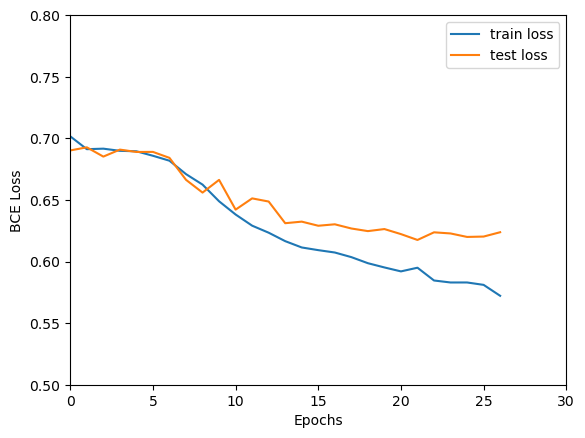

In [41]:
plt.plot(train_loss_values, label='train loss')
plt.plot(test_loss_values, label='test loss')

plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.xlim([0, 30])
plt.ylim([0.5, 0.8])
plt.legend()

plt.savefig(f'./loss_CNN_bat{train_loader.batch_size}_early{EARLY_STOPPING}_flit{net.filter_num}_100_1200_50_BN_1.png')
plt.show()

## 5. Validate model

In [33]:
net.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [44]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time


def DB_pubchemID_crowling(drug, df=None):
    
    chrome_option = webdriver.ChromeOptions()
    chrome_option.add_argument("headless")
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_option)
    
    # drugbank 홈페이지
    driver.get('https://go.drugbank.com/drugs/' + drug)

    err_list = []

    try:
        external_links = driver.find_element(By.ID, 'pubchem-compound')
        dd_element = external_links.find_element(By.XPATH, 'following-sibling::dd[1]')
        pubchem_id = dd_element.text
        if df is not None:
            df_add = pd.DataFrame({'#Drug': [drug], 'Pubchem CID': [pubchem_id]})
            # print(df_add)
            df = pd.concat([df, df_add], ignore_index=False)
                    
    except Exception as e:
        print("Error: ", e)
        err_list.append(drug)


    if len(err_list) != 0:
        print(f"Error: '{drug}' 정보 수집 실패")
    else:
        print(f"'{drug}'의 정보 수집 완료")
    driver.close()
    return pubchem_id

In [45]:
import requests
import re
url = 'https://rest.uniprot.org/uniprotkb/stream?compressed=false&format=fasta&query=%28organism_id%3A9606%29%20AND%20%28reviewed%3Atrue%29'
all_fastas = requests.get(url).text
fasta_list = re.split(r'\n(?=>)', all_fastas)

In [46]:
import pandas as pd
import pubchempy as pcp
chem_gene_original = pd.read_csv('./data/ChG-Miner_miner-chem-gene.tsv', sep='\t')
disease_chem_original = pd.read_csv('./data/DCh-Miner_miner-disease-chemical.tsv', sep='\t')

In [51]:
valid_df = pd.DataFrame(columns=['Chemical 1', 'Chemical 2'])
valid_df.loc[0] = ['DB01597', 'DB01059']

In [52]:
class ValidDataset(Dataset):
    def __init__(self, valid_df, gene_df=chem_gene_original):
        self.valid_df = valid_df
        self.gene_df = gene_df
        self.dbID_1 = self.valid_df['Chemical 1'][0]
        self.dbID_2 = self.valid_df['Chemical 2'][0]
        self.pubchemID_1 = self.make_pubchemID(self.dbID_1)
        self.pubchemID_2 = self.make_pubchemID(self.dbID_2)
        
        print(self.pubchemID_1, self.pubchemID_2)
    
    def make_pubchemID(self, drug_id):
        pubchem_id = DB_pubchemID_crowling(drug_id)
        return pubchem_id
        
    def __len__(self):
        return len(self.valid_df)
    
    def __getitem__(self, idx):
        return self.triplets()
    
    def make_smiles(self, pubchem_id):
        smiles = pcp.get_compounds(pubchem_id)[0].isomeric_smiles
        return smiles
    
    def make_genes(self, drug_id):
        genes = self.gene_df[self.gene_df['#Drug'] == drug_id]['Gene'].values
        
        seqs = []
        for i in range(len(genes)):
            for fasta in fasta_list:
                uniprot = genes[i]
                if uniprot in fasta:
                    seq = fasta.split(" ")[-1]
                    seq = seq.split('\n')[1:]
                    seq = ''.join(seq)
                    seqs.append(seq)
        return seqs

    def smiles2int(self, pubchem_id):
        smiles = self.make_smiles(pubchem_id)
        arr = [VOCAB_LIGAND_ISO[s] for s in smiles]   
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)))
        else:
            arr = arr[:100]
            arr = np.array(arr)
        return arr
    
    def seqs2int(self, gene):
        arr = [VOCAB_PROTEIN[g] for g in gene]   
        if len(arr) < 600:
            arr = np.pad(arr, (0, 600 - len(arr)))
        else:
            arr = arr[:600]
            arr = np.array(arr)
        return arr
    
    def protein_seq(self, drug_id):
        genes = self.make_genes(drug_id)
        seqs2int_list = []
        for gene in genes:
            seqs2int_list.append(self.seqs2int(gene))
        try:
            sum(seqs2int_list)
        except:
            return seqs2int_list
        
        return sum(seqs2int_list) / len(genes)
        
        
    def triplets(self):
        
        seqA = torch.tensor(self.protein_seq(self.dbID_1), dtype=torch.long)
        seqB = torch.tensor(self.protein_seq(self.dbID_2), dtype=torch.long)
        
        smilesA = torch.tensor(self.smiles2int(self.pubchemID_1), dtype=torch.long)
        smilesB = torch.tensor(self.smiles2int(self.pubchemID_2), dtype=torch.long)
        
        drugA = torch.cat((smilesA, seqA), 0)
        drugB = torch.cat((smilesB, seqB), 0)
        
        return drugA, drugB
    

In [53]:
valid_data = ValidDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size=1, shuffle=False, num_workers=4, drop_last=True)

'DB01597'의 정보 수집 완료
'DB01059'의 정보 수집 완료
6435415 4539


In [54]:
for data in valid_loader:
    drugA, drugB = data
    drugA = drugA.cuda()
    drugB = drugB.cuda()
    
    outputs = net(drugA, drugB)
    print(outputs)
    if outputs[0] < 0.5:
        print(f"{valid_df['Chemical 1'].iloc[0]} and {valid_df['Chemical 2'].iloc[0]} are not similar...")
    else:
        print(f"{valid_df['Chemical 1'].iloc[0]} and {valid_df['Chemical 2'].iloc[0]} are similar!!!")

tensor([[0.4059]], device='cuda:0', grad_fn=<SigmoidBackward0>)
DB01597 and DB01059 are not similar...
